Found 5070 images belonging to 13 classes.
Found 429 images belonging to 13 classes.


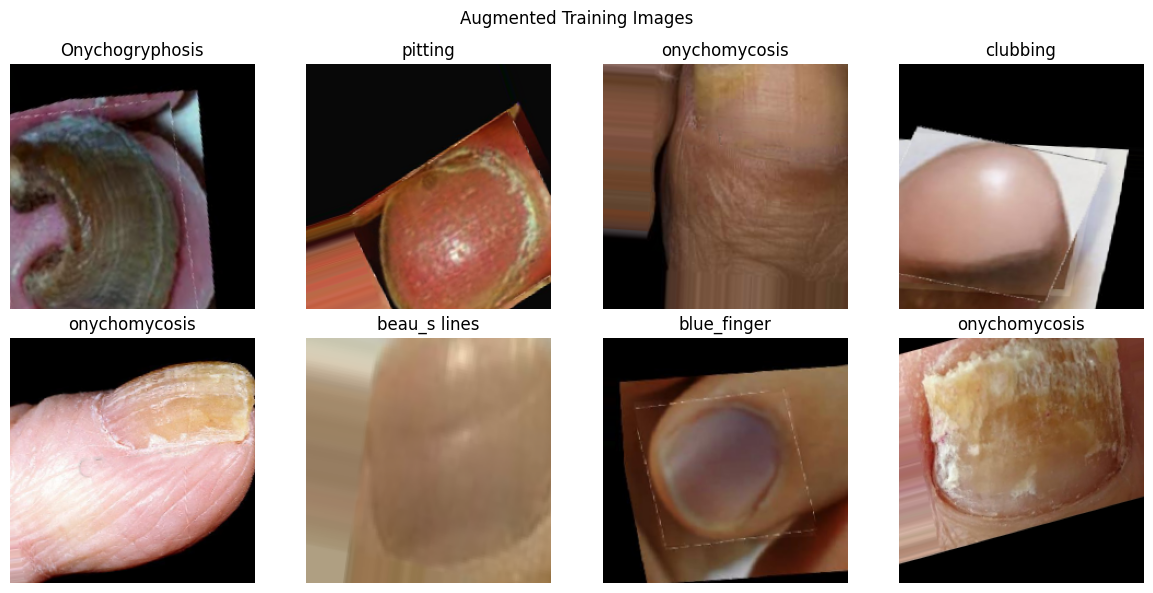

Epoch 1/10
  1/159 [..............................] - ETA: 21:04 - loss: 2.7876 - accuracy: 0.0312

KeyboardInterrupt: 

In [2]:
### import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import tensorflow as tf

# Paths
train_dir = 'dataset/train'
val_dir = 'dataset/test'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Data visualization with preprocessing
def visualize_augmented_data(generator, class_names):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(x_batch[i])
        label_index = np.argmax(y_batch[i])
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.suptitle("Augmented Training Images")
    plt.tight_layout()
    plt.show()

visualize_augmented_data(train_generator, list(train_generator.class_indices.keys()))

# Load pre-trained VGG19
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)
model.save('nail.h5')
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
class_labels = list(val_generator.class_indices.keys())
print(classification_report(val_generator.classes, y_pred, target_names=class_labels))


['Acral_Lentiginous_Melanoma', 'Onychogryphosis', 'beau_s lines', 'blue_finger', 'clubbing', 'healthy', 'koilonychia', 'onychomycosis', 'pitting', 'psoriasis', 'terry_s nail', 'white nail', 'yellow nails']
1/1 [==============================] - 0s 386ms/step


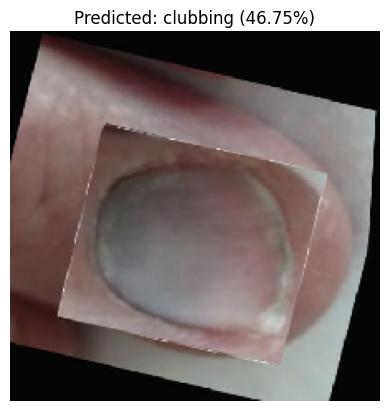

Predicted Class: clubbing
Confidence: 46.75%


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model('nail.h5')

# Class names
class_names = list(train_generator.class_indices.keys())
print(class_names)
[]
# Predict a single image
def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Display
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")

predict_single_image('test.jpg')  # Replace with your actual image path
